# Intro to Word Embeddings

In this notebook we learn about word2vec as a new technique to convert words into (dense) vectors, and re-build the text classification pipeline we had previously built with sparse vectors.

You are encouraged to play around with the code and modify / re-built parts of it as you fit: there is NO substitute for "tinkering with code" to understand how all the concepts fit together (corollary: all this code is written for pedagogical purposes, so some functions are re-used from previous lectures to provide a self-sufficient script).

In [1]:
import pandas as pd
from collections import Counter
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import string
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import gensim

/Users/apo/Documents/repos/MLSys-NYU-2023/weeks/12/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline

## Data loading

In [3]:
# some utils function
def get_finance_sentiment_dataset(split: str='sentences_allagree'):
    # load financial dataset from HF
    from datasets import load_dataset
    # https://huggingface.co/datasets/financial_phrasebank
    # by default, load just sentences for which all annotators agree
    dataset = load_dataset("financial_phrasebank", split)
    
    return dataset['train']


def get_finance_sentences():
    dataset = get_finance_sentiment_dataset()
    cleaned_dataset = [[pre_process_sentence(_['sentence']), _['label']] for _ in dataset]
    # debug 
    print("{} cleaned sentences from finance dataset\n".format(len(cleaned_dataset)))
    
    return cleaned_dataset


def pre_process_sentence(sentence: str):
    # this choices are VERY important. Here, we take a simplified 
    # view, remove the punctuations and just lower case everything
    lower_sentence = sentence.lower()
    exclude = set(string.punctuation)
    return ''.join(ch for ch in lower_sentence if ch not in exclude)

In [4]:
finance_dataset = get_finance_sentences()
# print out the first items in the dataset, to check the format
finance_dataset[:2]

2264 cleaned sentences from finance dataset



[['according to gran  the company has no plans to move all production to russia  although that is where the company is growing ',
  1],
 ['for the last quarter of 2010  componenta s net sales doubled to eur131m from eur76m for the same period a year earlier  while it moved to a zero pretax profit from a pretax loss of eur7m ',
  2]]

In [5]:
# get sentences without label for vectorizer part
finance_dataset_sentences = [_[0] for _ in finance_dataset]

## From words to vectors

Let us now use word2vec to get vectors for words first, and document after. We will use a fantastic Python library, gensim: https://radimrehurek.com/gensim/models/word2vec.html

In [6]:
def train_word2vec_model(
    sentences: list,
    min_count: int = 2,
    vector_size: int = 48,
    window: int = 2,
    epochs: int = 20
):
    """
    Sentences is a list of lists, where each list is composed by tokens in a sentence: e.g.
    
    [
        ['the', 'cat', 'is', 'on' ...],
        ['i', 'live', 'in', 'nyc', ...],
        ....
    ]
    
    """
    model =  gensim.models.Word2Vec(sentences=sentences,
                                    min_count=min_count,
                                    vector_size=vector_size,
                                    window=window,
                                    epochs=epochs)
    
    # this is how many words we will have in the space
    print("# words in the space: {}".format(len(model.wv.index_to_key)))

    # we return the space in a format that will allow us to do nice things afterwards ;-)    
    return model.wv

In [7]:
# let's use nltk tokenizer to break up sentences and build a word2vec model
# https://www.nltk.org/api/nltk.tokenize.html
from nltk.tokenize import word_tokenize

print(finance_dataset_sentences[0], '\n\n', word_tokenize(finance_dataset_sentences[0]))

according to gran  the company has no plans to move all production to russia  although that is where the company is growing  

 ['according', 'to', 'gran', 'the', 'company', 'has', 'no', 'plans', 'to', 'move', 'all', 'production', 'to', 'russia', 'although', 'that', 'is', 'where', 'the', 'company', 'is', 'growing']


In [8]:
tokenized_sentences = [word_tokenize(_) for _ in finance_dataset_sentences]
# debug 
tokenized_sentences[:2]

[['according',
  'to',
  'gran',
  'the',
  'company',
  'has',
  'no',
  'plans',
  'to',
  'move',
  'all',
  'production',
  'to',
  'russia',
  'although',
  'that',
  'is',
  'where',
  'the',
  'company',
  'is',
  'growing'],
 ['for',
  'the',
  'last',
  'quarter',
  'of',
  '2010',
  'componenta',
  's',
  'net',
  'sales',
  'doubled',
  'to',
  'eur131m',
  'from',
  'eur76m',
  'for',
  'the',
  'same',
  'period',
  'a',
  'year',
  'earlier',
  'while',
  'it',
  'moved',
  'to',
  'a',
  'zero',
  'pretax',
  'profit',
  'from',
  'a',
  'pretax',
  'loss',
  'of',
  'eur7m']]

In [9]:
# build a counter to get a sense of the lexicon
word_counter = Counter([item for sent in tokenized_sentences for item in sent])
word_counter.most_common(20)

[('the', 2730),
 ('of', 1525),
 ('in', 1384),
 ('and', 1166),
 ('to', 1081),
 ('eur', 756),
 ('a', 725),
 ('for', 541),
 ('from', 517),
 ('s', 456),
 ('mn', 439),
 ('is', 415),
 ('company', 349),
 ('will', 346),
 ('profit', 322),
 ('by', 303),
 ('net', 292),
 ('as', 274),
 ('on', 272),
 ('million', 266)]

In [10]:
w2v_model = train_word2vec_model(tokenized_sentences)

# words in the space: 2920


Now that we have a vector space, let's find words similar to a given term...

In [11]:
for w in ['company', 'profit']:
    print('\n======>{}\n'.format(w), w2v_model.similar_by_word(w, topn=3))


======>company
 [('group', 0.9100959897041321), ('media', 0.8791838884353638), ('bank', 0.8731065988540649)]

======>profit
 [('loss', 0.9652982950210571), ('income', 0.9271997213363647), ('margin', 0.9108799695968628)]


To get a sense of what the vectors look like, we print them out in 2D using TSNE (https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html):

In [12]:
def plot_scatter_by_category_with_lookup(title, 
                                         words, 
                                         word_to_target_cat,
                                         results):
    """
    Just a plotting routine
    """
    
    groups = {}
    for word, target_cat in word_to_target_cat.items():
        if word not in words:
            continue

        word_idx = words.index(word)
        x = results[word_idx][0]
        y = results[word_idx][1]
        if target_cat in groups:
            groups[target_cat]['x'].append(x)
            groups[target_cat]['y'].append(y)
        else:
            groups[target_cat] = {
                'x': [x], 'y': [y]
                }
    
    fig, ax = plt.subplots(figsize=(10, 10))
    for group, data in groups.items():
        ax.scatter(data['x'], data['y'], 
                   alpha=0.1 if group == 0 else 0.8, 
                   edgecolors='none', 
                   s=25, 
                   marker='o',
                   label=group)

    plt.title(title)
    plt.legend(loc=2)
    plt.show()
    
    return

In [13]:
def tsne_analysis(embeddings, perplexity=25, n_iter=500):
    tsne = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=n_iter)
    return tsne.fit_transform(embeddings)

In [14]:
# map words to known categories of interest

# 0 is the generic category
words = w2v_model.index_to_key
print(len(words))
words_to_category = {w: 0 for w in words}
# manually pick some words to display
for w in ['company', 'profit', 'investment', 'loss', 'margin', 'group']:
    words_to_category[w] = 1
for w in ['with', 'of', 'from', 'by', 'as']:
    words_to_category[w] = 2

2920


In [15]:
embeddings = np.array([w2v_model[w] for w in words])
embeddings[0]

array([ 1.0645146 , -0.02781337,  0.7804133 ,  0.7652676 , -0.05879437,
        0.09922378,  0.13741404,  0.39410672,  0.45476937, -0.65338624,
        0.59099895,  0.661807  ,  0.17931135, -0.10444742, -0.31074393,
       -0.307779  ,  1.0025209 , -0.34080386, -0.80137503, -0.4315046 ,
        1.2739598 ,  0.14759225,  1.2450421 ,  0.12141451,  0.0902983 ,
       -0.49496412, -0.73029363, -0.50878364,  0.7165489 , -0.48546085,
       -1.2153037 , -0.08253049,  0.35617816, -0.23308773, -0.11823951,
        0.8373862 ,  0.6906727 ,  0.40704912,  0.40186352, -0.06334019,
       -0.9505231 ,  0.27927026, -0.6650923 , -0.6675039 ,  0.6523567 ,
       -0.04184781,  0.284997  ,  0.6959411 ], dtype=float32)

In [16]:
tsne_results = tsne_analysis(embeddings)
assert len(tsne_results) == len(words)

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 2920 samples in 0.001s...
[t-SNE] Computed neighbors for 2920 samples in 0.341s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2920
[t-SNE] Computed conditional probabilities for sample 2000 / 2920
[t-SNE] Computed conditional probabilities for sample 2920 / 2920
[t-SNE] Mean sigma: 0.075254
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.373230
[t-SNE] KL divergence after 500 iterations: 1.516992


/Users/apo/Documents/repos/MLSys-NYU-2023/weeks/12/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/apo/Documents/repos/MLSys-NYU-2023/weeks/12/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/apo/Documents/repos/MLSys-NYU-2023/weeks/12/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)

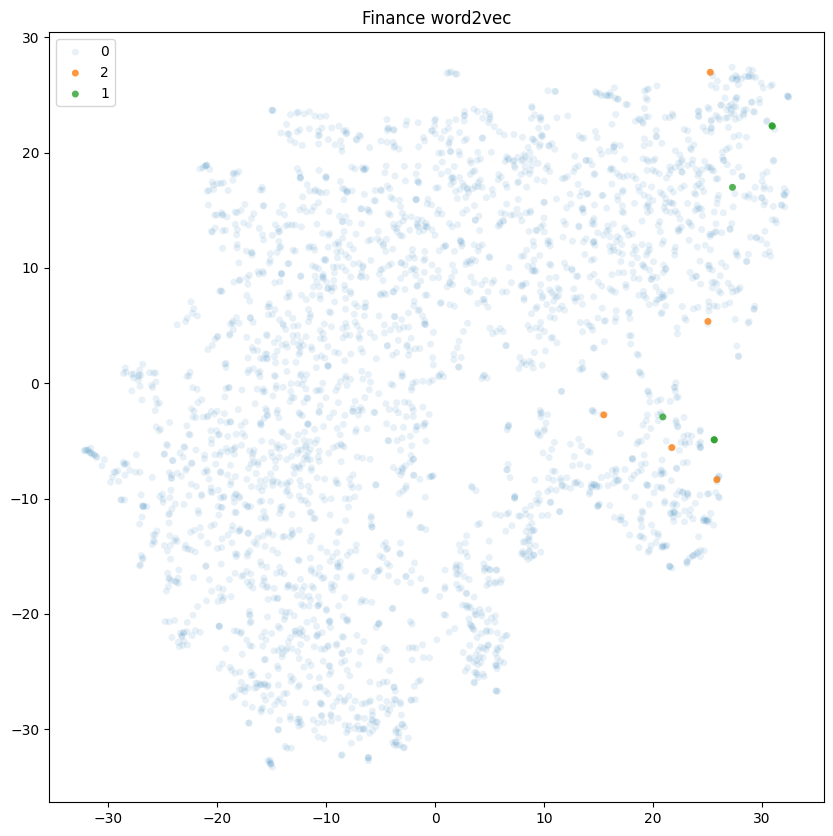

In [17]:
plot_scatter_by_category_with_lookup('Finance word2vec', words, words_to_category, tsne_results)

_Why the quality is not great?_

Our dataset is very small, and word2vec works much better when large corpora are used. However, a pretty cool things of language is that is everywhere: the word "company" is very important in the financial sector, but of course also Wikipedia talks a lot about companies... can we make use of all the text out there?

The answer is YES: in particular, a pattern that is common to many NLP (but also vision-related) tasks is to initialize a model with PRE-TRAINED embeddings, obtained previously with training on large corpora. We could either re-use them or "fine-tune" them: in either case, we will, so to speak, be able to harness the power of Wikipedia even in a corpus very small such as ours.

### Bonus: using pre-trained embeddings

Here we use Gensim-data to recover dense vectors for words in our vocabulary, as pre-trained on Wikipedia.

In [18]:
# glove-wiki-gigaword-50 (400000 records): Pre-trained vectors based on Wikipedia
pre_trained_model = api.load("glove-wiki-gigaword-50")
# test it out
for w in ['company', 'profit']:
    print('\n======>{}\n'.format(w), pre_trained_model.similar_by_word(w, topn=3))


======>company
 [('firm', 0.8884971141815186), ('subsidiary', 0.8764045238494873), ('companies', 0.8662536144256592)]

======>profit
 [('earnings', 0.9254103899002075), ('profits', 0.9171135425567627), ('shares', 0.8507129549980164)]


In [19]:
words =[w for w in w2v_model.index_to_key if w in pre_trained_model]
print(len(words))
pre_trained_vectors = np.array([pre_trained_model[w] for w in words])
pre_trained_tsne_results = tsne_analysis(pre_trained_vectors)

2672
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 2672 samples in 0.000s...
[t-SNE] Computed neighbors for 2672 samples in 0.246s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2672
[t-SNE] Computed conditional probabilities for sample 2000 / 2672
[t-SNE] Computed conditional probabilities for sample 2672 / 2672
[t-SNE] Mean sigma: 1.285567
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.653107
[t-SNE] KL divergence after 500 iterations: 1.907890


/Users/apo/Documents/repos/MLSys-NYU-2023/weeks/12/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/apo/Documents/repos/MLSys-NYU-2023/weeks/12/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/apo/Documents/repos/MLSys-NYU-2023/weeks/12/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)

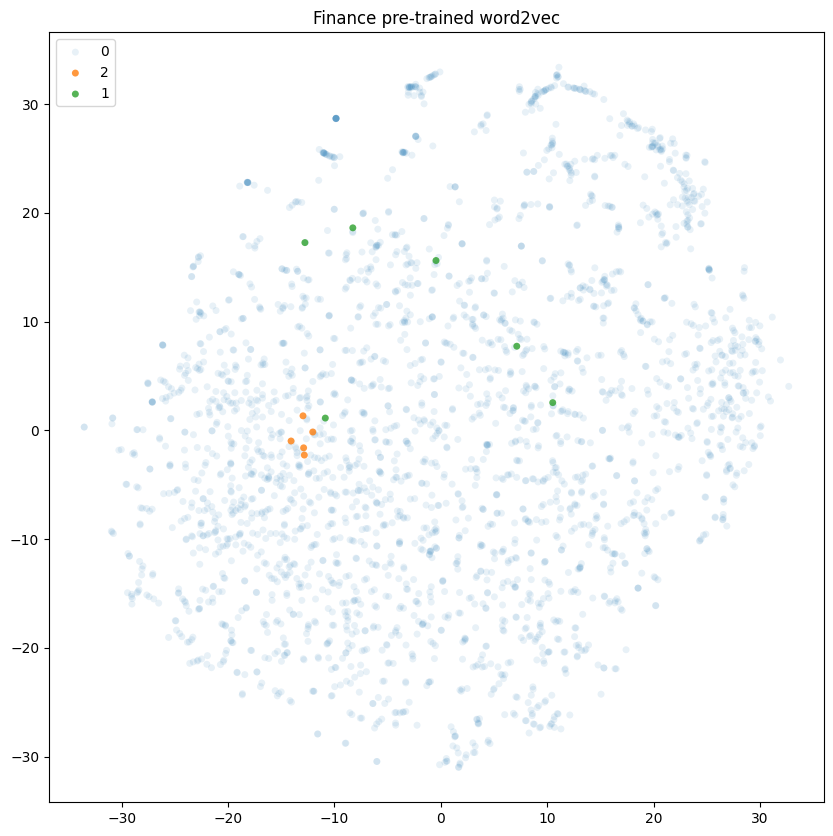

In [20]:
plot_scatter_by_category_with_lookup('Finance pre-trained word2vec', 
                                     words, 
                                     words_to_category, 
                                     pre_trained_tsne_results)

## Application: Text Classification Revisited

As you may recall, one text is in a vectorized form, the downstream pipeline we learned through scikit can be applied in the same way to language dataset. For convenience, we report again a standard classifier for financial news built with TF-IDF transformation first, and then use word2vec to the same.

In [21]:
finance_dataset_text = [_[0] for _ in finance_dataset]
finance_dataset_label = [_[1] for _ in finance_dataset]
all_labels = set(finance_dataset_label)
print("All labels are: {}".format(all_labels))
X_train, X_test, y_train, y_test = train_test_split(finance_dataset_text, 
                                                    finance_dataset_label, 
                                                    test_size=0.1, 
                                                    random_state=42)

print(len(X_train))
final_tfidfvectorizer = TfidfVectorizer(analyzer='word', stop_words='english')
final_tfidf_train = final_tfidfvectorizer.fit_transform(X_train)
print(final_tfidf_train.shape)
X_test_transformed = final_tfidfvectorizer.transform(X_test)

All labels are: {0, 1, 2}
2037
(2037, 6065)


In [22]:
model = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
model.fit(final_tfidf_train, y_train)
predicted = model.predict(X_test_transformed)
predicted_prob = model.predict_proba(X_test_transformed)

In [23]:
def calculate_confusion_matrix_and_report(y_predicted, y_golden, with_plot=True):
    # calculate confusion matrix: 
    cm = confusion_matrix(y_golden, y_predicted)
    # build a readable report;
    # https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report
    print('\nClassification Report')
    print(classification_report(y_golden, y_predicted))
    # plot the matrix
    if with_plot:
        plot_confusion_matrix(cm)
                                          
    return
                                          
def plot_confusion_matrix(c_matrix):
    plt.imshow(c_matrix, cmap=plt.cm.Blues)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title("Confusion matrix")
    plt.colorbar()
    plt.show()
    
    return

Total of # 227 test cases

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.64      1.00      0.78       145
           2       0.00      0.00      0.00        52

    accuracy                           0.64       227
   macro avg       0.21      0.33      0.26       227
weighted avg       0.41      0.64      0.50       227



/Users/apo/Documents/repos/MLSys-NYU-2023/weeks/12/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/apo/Documents/repos/MLSys-NYU-2023/weeks/12/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/apo/Documents/repos/MLSys-NYU-2023/weeks/12/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

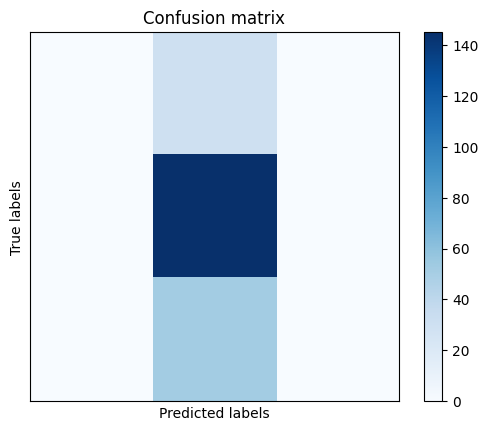

In [24]:
print("Total of # {} test cases".format(len(y_test)))
calculate_confusion_matrix_and_report(predicted, y_test)

Let us know transform sentences using word2vec - we go through each of the sentence, remove stop words and take the average of the vector if present.

In [25]:
# debug some vars to make sure all is in order
print(w2v_model.most_similar("company"))
print(X_train[0],y_train[0])
print(X_test[0], y_test[0])

[('group', 0.9100959897041321), ('media', 0.8791838884353638), ('bank', 0.8731065988540649), ('report', 0.857915461063385), ('kemira', 0.8514637351036072), ('investment', 0.8499586582183838), ('glaston', 0.8466282486915588), ('alma', 0.8450238704681396), ('examining', 0.8379510641098022), ('stockmann', 0.8361465334892273)]
the train is expected to cross the russian territory in 9 days  reaching the vostochny port  1
the contract value amounts to eur 24 million  1


In [26]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words[:10]

[nltk_data] Downloading package stopwords to /Users/apo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [27]:
def tokenize(sentence, stop_words):
    return [w for w in word_tokenize(sentence) if w not in stop_words]


def sentence_to_embedding(sentence, model, stop_words, dims=48):
    tokenized_sentence = tokenize(sentence, stop_words)
    if not tokenized_sentence:
        print("\n!!!ATTENTION!!! Empty sentence: {}".format(sentence))
        return np.zeros(dims)
    mean_array = np.mean([model[w] for w in tokenized_sentence if w in model] or [np.zeros(dims)], axis=0)
    assert len(mean_array) == dims
    
    return np.array(mean_array)

# debug
_test = 'company profits were soaring last year'
print(tokenize(_test, stop_words))
print(sentence_to_embedding(_test, w2v_model, stop_words))

['company', 'profits', 'soaring', 'last', 'year']
[ 0.07921533 -0.47967702  0.44640243  0.17531554 -0.35575035 -0.28162384
 -0.30499613 -0.11937709 -0.17667572 -0.09304845  0.44833067  0.706299
  0.31762716 -0.4622425  -0.9071204   0.01409787 -0.13023846 -0.25811633
 -0.13434583  0.17056495  0.83591896  0.33157796  0.8445971   0.00724287
  0.50373095 -0.11928733  0.02459162 -0.6205206   0.0333083  -0.43438065
 -0.7179146   0.04637229  0.07548059  0.14603628  0.59304446 -0.03938942
  0.4647014   0.08291239  0.6639839  -0.10474465 -0.40074673  0.31510416
  0.5001475  -0.5929693  -0.31259608 -0.31851086  0.81310695  0.01911766]


In [28]:
# Q: instead of taking the average, can we weight "more" embeddings which are more important?
# e.g. can we use tf-idf as a weighting scheme to aggregate word vectors?

In [29]:
w2vec_X_train = np.array([sentence_to_embedding(_, w2v_model, stop_words) for _ in X_train])
w2vec_X_test = np.array([sentence_to_embedding(_, w2v_model, stop_words) for _ in X_test])
print(len(w2vec_X_train))
w2vec_X_train[0]


!!!ATTENTION!!! Empty sentence: it s not 
2037


array([-0.07931461, -0.24671496,  0.22679135,  0.16524589, -0.13098767,
       -0.08657072, -0.0183881 , -0.09278997, -0.18699445,  0.13330802,
       -0.04899958,  0.18256399,  0.00831239, -0.42740241, -0.24019854,
       -0.25973079, -0.03542053, -0.21133791, -0.00265733,  0.057982  ,
        0.53591973,  0.14967074,  0.35139045, -0.27358085,  0.17161842,
        0.0708657 , -0.50519228, -0.27960911, -0.02530256, -0.06593819,
       -0.38643816, -0.13823643,  0.18544216,  0.03721313,  0.14837061,
        0.08879101,  0.25935364,  0.11698921,  0.13414218,  0.1052558 ,
       -0.19285044,  0.11357834,  0.09019763, -0.22202492, -0.05493389,
       -0.09134506,  0.3486045 ,  0.27908641])

Total of # 227 test cases

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.84      0.93      0.88       145
           2       0.53      0.67      0.59        52

    accuracy                           0.75       227
   macro avg       0.46      0.53      0.49       227
weighted avg       0.66      0.75      0.70       227



/Users/apo/Documents/repos/MLSys-NYU-2023/weeks/12/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/apo/Documents/repos/MLSys-NYU-2023/weeks/12/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/apo/Documents/repos/MLSys-NYU-2023/weeks/12/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

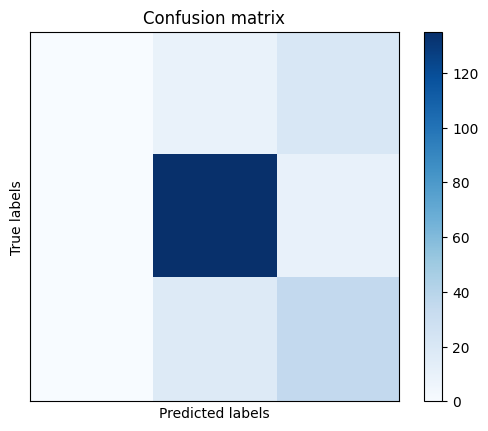

In [30]:
model = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
model.fit(w2vec_X_train, y_train)
predicted = model.predict(w2vec_X_test)
print("Total of # {} test cases".format(len(y_test)))
calculate_confusion_matrix_and_report(predicted, y_test)

### Bonus: let's use pre-trained vectors instead

In [31]:
# get the model again
pre_trained_model = api.load("glove-wiki-gigaword-50")
# re-vectorize the Xs - make sure to specify the right size for the embeddings
pre_trained_w2vec_X_train = np.array([sentence_to_embedding(_, pre_trained_model, stop_words, dims=50) for _ in X_train])
pre_trained_w2vec_X_test = np.array([sentence_to_embedding(_, pre_trained_model, stop_words, dims=50) for _ in X_test])
print(len(pre_trained_w2vec_X_train))
pre_trained_w2vec_X_train[0]


!!!ATTENTION!!! Empty sentence: it s not 
2037


array([ 0.51924288,  0.30214769,  0.27053925, -0.01674799, -0.0906771 ,
       -0.36139947, -0.45617181,  0.41620979, -0.05733399, -0.39408398,
        0.19038001, -0.48644575,  0.1145097 ,  0.0768772 ,  0.12969579,
       -0.010885  , -0.11613899,  0.00987101, -0.73364407,  0.09442971,
        0.27611277, -0.19260749, -0.13825601,  0.10901461,  0.0702723 ,
       -1.25034356,  0.35610753,  0.10629433,  0.26634151,  0.0314981 ,
        2.55075002,  0.15847002, -0.38198298,  0.00573248,  0.158932  ,
       -0.1249515 ,  0.02447074,  0.0259792 , -0.23428932,  0.2765944 ,
       -0.08744301,  0.0335037 ,  0.64398611, -0.615363  , -0.37974659,
        0.04422089, -0.036425  ,  0.04143619, -0.009764  , -0.37689099])

Total of # 227 test cases

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        30
           1       0.80      0.92      0.86       145
           2       0.48      0.56      0.51        52

    accuracy                           0.71       227
   macro avg       0.43      0.49      0.46       227
weighted avg       0.62      0.71      0.66       227



/Users/apo/Documents/repos/MLSys-NYU-2023/weeks/12/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/apo/Documents/repos/MLSys-NYU-2023/weeks/12/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/apo/Documents/repos/MLSys-NYU-2023/weeks/12/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

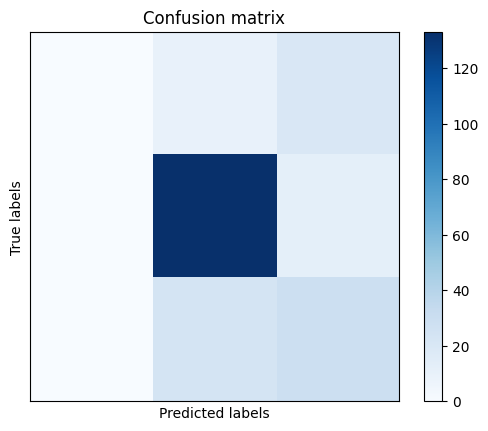

In [32]:
model = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
model.fit(pre_trained_w2vec_X_train, y_train)
predicted = model.predict(pre_trained_w2vec_X_test)
print("Total of # {} test cases".format(len(y_test)))
calculate_confusion_matrix_and_report(predicted, y_test)

## Word2vec for analogies

A famous property of word2vec is the ability to capture analogical relations through the embedding space, such as for example:

man : king = woman : ?

We re-use a pre-trained model, trained on wikipedia, to show how analogies are encoded in the latent space.

In [33]:
# get a model trained on twitter: https://radimrehurek.com/gensim/auto_examples/howtos/run_downloader_api.html
pre_trained_model = api.load("glove-twitter-50")

In [34]:
def analogy(model, worda, wordb, wordc):
    result = model.most_similar(negative=[worda], 
                                positive=[wordb, wordc])
    return result[0][0]

In [35]:
print(analogy(pre_trained_model, 'king', 'man', 'queen'))

girl


In [36]:
countries = ['australia', 'canada', 'germany', 'ireland', 'italy']
foods = [analogy(pre_trained_model, 'us', 'hamburger', country) for country in countries]

In [37]:
for c, f in zip(countries, foods):
    print(c, f)

australia hopman
canada cheeseburger
germany lasagne
ireland lasagne
italy bolognese


## What's next?

We have discussed how to turn word into vectors using neural network - can we do the same to the entire sentence, without recurring to the mean trick?

YES, but training models that work well on sentences require a huge amount of computation. However, the same logic applies here: we can take a model that has been pre-trained on a very large corpus, and use it to vectorize our finance dataset.

As an example, we will use the convenient sentence transformer (https://github.com/UKPLab/sentence-transformers) to map text to a dense vector.

In [38]:
sentence_model = SentenceTransformer('stsb-distilbert-base')

In [39]:
# run example code to check all is good with the library
sentences = [
    'This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.', 
    'The quick brown fox jumps over the lazy dog.'
]
sentence_embeddings = sentence_model.encode(sentences)
for sentence, embedding in zip(sentences, sentence_embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding[:10])
    print("")

Sentence: This framework generates embeddings for each input sentence
Embedding: [-0.21486233  0.3957226   0.46908706  0.13617705  0.00691138  0.4299766
  1.0304948  -0.08202254  0.22088987 -0.878799  ]

Sentence: Sentences are passed as a list of string.
Embedding: [-0.4400174  -0.28488478  0.23363847  0.553784    0.20757261 -0.07394984
  0.17051984 -0.76089996 -1.073092    0.48331803]

Sentence: The quick brown fox jumps over the lazy dog.
Embedding: [-0.29504803 -0.24928837 -0.02407111 -0.07039169 -0.29811606  0.7069692
 -0.74239254 -0.7840703   0.3461391   0.16320239]



In [40]:
def bert_sentence_encoding(sentences, model):
    # this takes a while!
    embedded_sentences = model.encode(sentences)
    assert len(embedded_sentences) == len(sentences)
    
    return embedded_sentences

In [41]:
# re-vectorize the Xs - make sure to specify the right size for the embeddings
bert_w2vec_X_train = np.array(bert_sentence_encoding(X_train, sentence_model))
bert_w2vec_X_test = np.array(bert_sentence_encoding(X_test, sentence_model))
print(bert_w2vec_X_train[0].shape)

(768,)


Total of # 227 test cases

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.33      0.50        30
           1       0.76      0.98      0.85       145
           2       0.76      0.42      0.54        52

    accuracy                           0.77       227
   macro avg       0.84      0.58      0.63       227
weighted avg       0.79      0.77      0.74       227



/Users/apo/Documents/repos/MLSys-NYU-2023/weeks/12/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/apo/Documents/repos/MLSys-NYU-2023/weeks/12/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)
/Users/apo/Documents/repos/MLSys-NYU-2023/weeks/12/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.canvas.print_figure(bytes_io, **kw)

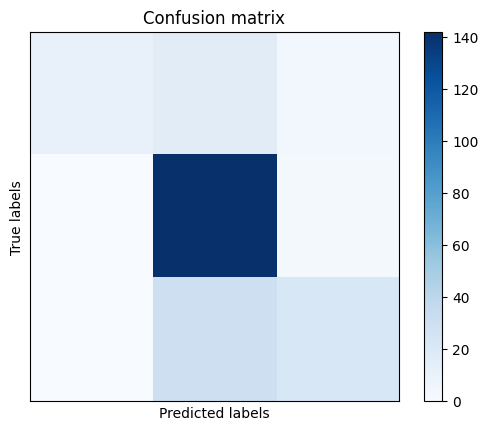

In [42]:
model = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0)
model.fit(bert_w2vec_X_train, y_train)
predicted = model.predict(bert_w2vec_X_test)
print("Total of # {} test cases".format(len(y_test)))
calculate_confusion_matrix_and_report(predicted, y_test)